## 1. Import libraries

In [76]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

## 2. Read data

In [41]:
churn_data = pd.read_csv('files_for_lab/Customer-Churn.csv')
churn_data.columns = churn_data.columns.str.lower().str.replace(' ', '_')
churn_data

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,monthlycharges,totalcharges,churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,No,Yes,Yes,Yes,Yes,One year,84.80,1990.5,No
7039,Female,0,Yes,Yes,72,Yes,No,Yes,Yes,No,Yes,Yes,One year,103.20,7362.9,No
7040,Female,0,Yes,Yes,11,No,Yes,No,No,No,No,No,Month-to-month,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,No,No,No,No,No,No,Month-to-month,74.40,306.6,Yes


## 3. Check dtypes

In [42]:
churn_data.dtypes

gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

In [43]:
churn_data['totalcharges'] = churn_data['totalcharges'].astype('float')

ValueError: could not convert string to float: ' '

## 4. Check and replace nulls

In [44]:
for col in churn_data:
    print(churn_data[col].value_counts())
    print()

Male      3555
Female    3488
Name: gender, dtype: int64

0    5901
1    1142
Name: seniorcitizen, dtype: int64

No     3641
Yes    3402
Name: partner, dtype: int64

No     4933
Yes    2110
Name: dependents, dtype: int64

1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64

Yes    6361
No      682
Name: phoneservice, dtype: int64

No                     3498
Yes                    2019
No internet service    1526
Name: onlinesecurity, dtype: int64

No                     3088
Yes                    2429
No internet service    1526
Name: onlinebackup, dtype: int64

No                     3095
Yes                    2422
No internet service    1526
Name: deviceprotection, dtype: int64

No                     3473
Yes                    2044
No internet service    1526
Name: techsupport, dtype: int64

No                     2810
Yes                    2707
No internet service    1526
Name: str

In [45]:
pd.set_option("display.max_rows", None)

select_cols = ['tenure', 'monthlycharges', 'totalcharges']
for col in select_cols:
    print('nans:', churn_data[col].isna().sum())
    print(churn_data[col].value_counts().sort_index())
    print()
    
pd.set_option("display.max_rows", 20)

nans: 0
0      11
1     613
2     238
3     200
4     176
5     133
6     110
7     131
8     123
9     119
10    116
11     99
12    117
13    109
14     76
15     99
16     80
17     87
18     97
19     73
20     71
21     63
22     90
23     85
24     94
25     79
26     79
27     72
28     57
29     72
30     72
31     65
32     69
33     64
34     65
35     88
36     50
37     65
38     59
39     56
40     64
41     70
42     65
43     65
44     51
45     61
46     74
47     68
48     64
49     66
50     68
51     68
52     80
53     70
54     68
55     64
56     80
57     65
58     67
59     60
60     76
61     76
62     70
63     72
64     80
65     76
66     89
67     98
68    100
69     95
70    119
71    170
72    362
Name: tenure, dtype: int64

nans: 0
18.25      1
18.40      1
18.55      1
18.70      2
18.75      1
18.80      7
18.85      5
18.90      2
18.95      6
19.00      7
19.05      9
19.10     12
19.15     11
19.20     17
19.25     18
19.30     24
19.35     25
19.40

In [46]:
churn_data.loc[churn_data['totalcharges'] == ' ', 'totalcharges'] = np.nan
churn_data['totalcharges'] = churn_data['totalcharges'].astype('float')

In [47]:
churn_data['totalcharges'].fillna(churn_data['totalcharges'].mean(), inplace=True)

In [48]:
churn_data['totalcharges'].isna().sum()

0

## 5. tenure, seniorcitizen, monthlycharges, totalcharges
### a. Scale features

In [49]:
df = churn_data.copy()

In [50]:
cols_scale = df[['tenure', 'seniorcitizen', 'monthlycharges', 'totalcharges']].copy()

In [51]:
scaler = StandardScaler()
cols_scale = scaler.fit_transform(cols_scale)

In [52]:
df.update(cols_scale)

### b. Train Test split

In [53]:
df.dtypes

gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
monthlycharges      float64
totalcharges        float64
churn                object
dtype: object

In [54]:
y = df['churn']
X = df.drop('churn', axis=1)

In [55]:
X = pd.get_dummies(X, columns=X.select_dtypes('object').columns.tolist())
X

,seniorcitizen,tenure,monthlycharges,totalcharges,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,...,techsupport_Yes,streamingtv_No,streamingtv_No internet service,streamingtv_Yes,streamingmovies_No,streamingmovies_No internet service,streamingmovies_Yes,contract_Month-to-month,contract_One year,contract_Two year
0,0,1,29.85,29.85,1,0,0,1,1,0,...,0,1,0,0,1,0,0,1,0,0
1,0,34,56.95,1889.50,0,1,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
2,0,2,53.85,108.15,0,1,1,0,1,0,...,0,1,0,0,1,0,0,1,0,0
3,0,45,42.30,1840.75,0,1,1,0,1,0,...,1,1,0,0,1,0,0,0,1,0
4,0,2,70.70,151.65,1,0,1,0,1,0,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,1990.50,0,1,0,1,0,1,...,1,0,0,1,0,0,1,0,1,0
7039,0,72,103.20,7362.90,1,0,0,1,0,1,...,0,0,0,1,0,0,1,0,1,0
7040,0,11,29.60,346.45,1,0,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0
7041,1,4,74.40,306.60,0,1,0,1,1,0,...,0,1,0,0,1,0,0,1,0,0


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### c. Fit logistic regression model

In [68]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [69]:
classification = LogisticRegression(random_state=42, max_iter=1000)
classification.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

<Axes: >

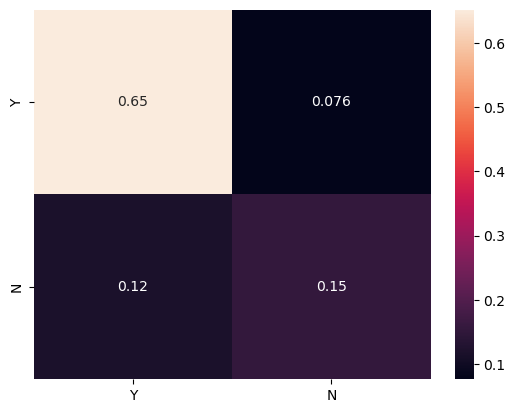

In [70]:
predictions = classification.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=classification.classes_, normalize='all')
sns.heatmap(cm, annot=True, xticklabels=["Y", "N"], yticklabels=["Y", "N"])

### d. Check accuracy

In [71]:
classification.score(X_test, y_test)

0.8059630856601988

In [72]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          No       0.85      0.90      0.87      1539
         Yes       0.67      0.57      0.61       574

    accuracy                           0.81      2113
   macro avg       0.76      0.73      0.74      2113
weighted avg       0.80      0.81      0.80      2113



## 6. Check for imbalance

In [73]:
y_train.value_counts()

No     3635
Yes    1295
Name: churn, dtype: int64

## 7. Resampling to create balance

#### a. SMOTE

In [79]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
y_train_smote.value_counts()

No     3635
Yes    3635
Name: churn, dtype: int64

#### b. randomOverSampler

In [80]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
y_train_ros.value_counts()

No     3635
Yes    3635
Name: churn, dtype: int64

#### c. randomUnderSampler

In [81]:
rus = RandomUnderSampler(random_state=42)

X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
y_train_rus.value_counts()

No     1295
Yes    1295
Name: churn, dtype: int64

## 8. Test fit models and compare accuracy

#### a. SMOTE

In [82]:
classification = LogisticRegression(random_state=42, max_iter=1000)
classification.fit(X_train_smote, y_train_smote)
predictions = classification.predict(X_test)
classification.score(X_test, y_test)

0.7524846190250828

In [83]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          No       0.92      0.73      0.81      1539
         Yes       0.53      0.82      0.64       574

    accuracy                           0.75      2113
   macro avg       0.72      0.77      0.73      2113
weighted avg       0.81      0.75      0.77      2113



#### b. randomOverSampler

In [84]:
classification = LogisticRegression(random_state=42, max_iter=1000)
classification.fit(X_train_ros, y_train_ros)
predictions = classification.predict(X_test)
classification.score(X_test, y_test)

0.7486985328916232

In [85]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          No       0.92      0.72      0.81      1539
         Yes       0.52      0.82      0.64       574

    accuracy                           0.75      2113
   macro avg       0.72      0.77      0.72      2113
weighted avg       0.81      0.75      0.76      2113



#### c. randomUnderSampler

In [86]:
classification = LogisticRegression(random_state=42, max_iter=1000)
classification.fit(X_train_rus, y_train_rus)
predictions = classification.predict(X_test)
classification.score(X_test, y_test)

0.7444391859914813

In [87]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          No       0.92      0.71      0.80      1539
         Yes       0.52      0.84      0.64       574

    accuracy                           0.74      2113
   macro avg       0.72      0.77      0.72      2113
weighted avg       0.81      0.74      0.76      2113

